In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

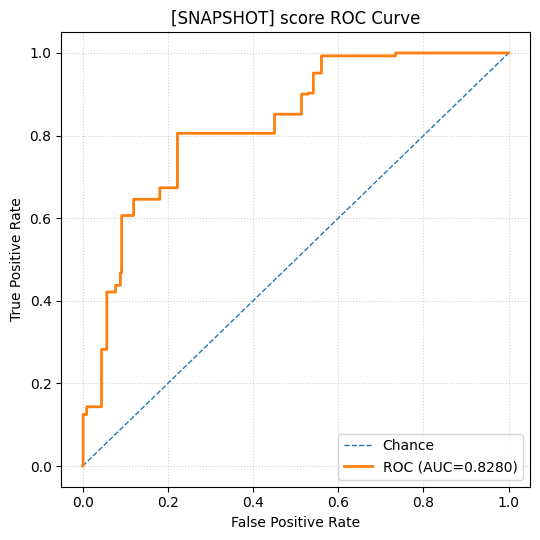

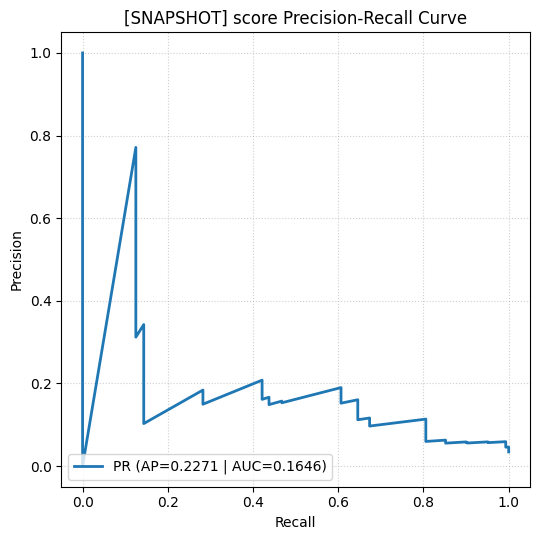

[SNAPSHOT] score ROC-AUC: 0.828001
[SNAPSHOT] score Average Precision (AP): 0.227102
[SNAPSHOT] score PR-AUC (trapz): 0.164592
Positives: 432 / 12623 (prevalence=0.0342)


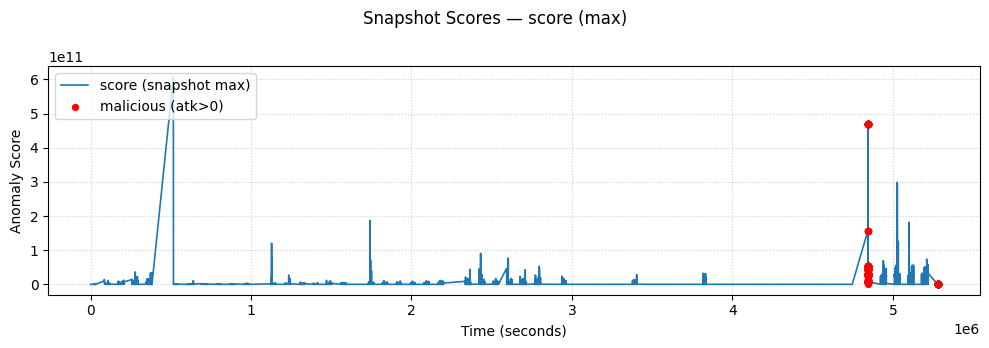

In [ ]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "anomrank_user1_combined_or_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        # "max" | "mean" | "sum"
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   # "snapshot" | "edge"
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    """Compute ROC-AUC, AP, PR-AUC and plot ROC/PR curves."""
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"[SNAPSHOT] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


User7

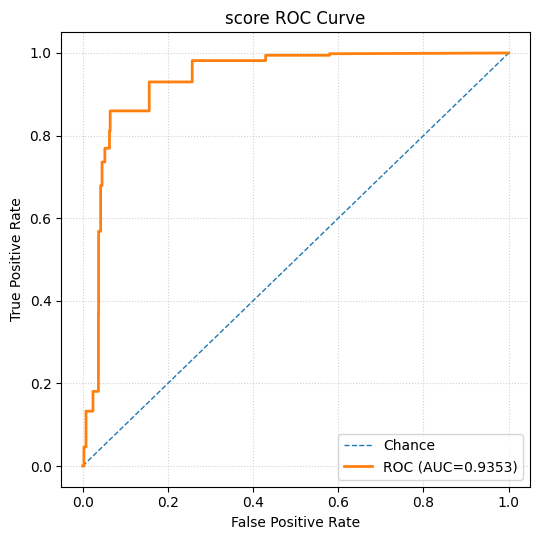

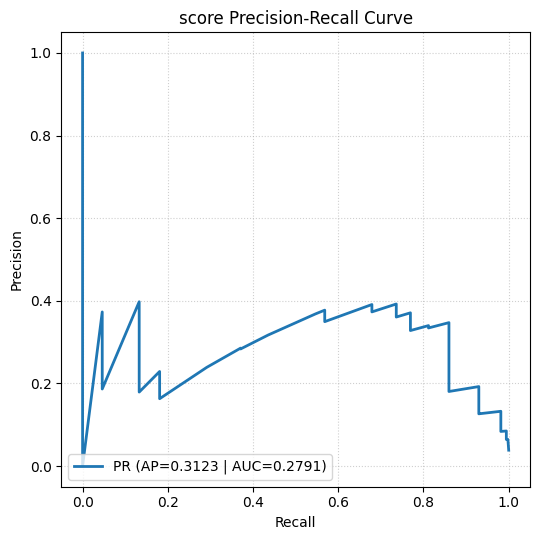

score ROC-AUC: 0.935276
score Average Precision (AP): 0.312286
score PR-AUC (trapz): 0.279133
Positives: 542 / 14068 (prevalence=0.0385)


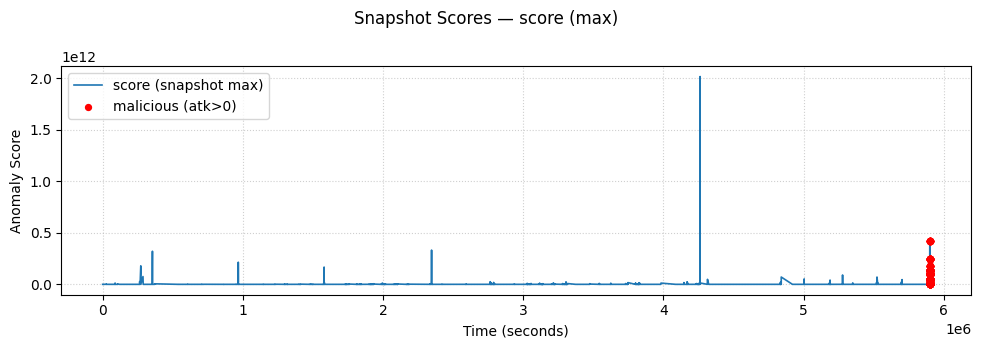

In [17]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "anomrank_user7_combined_or_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


User 12

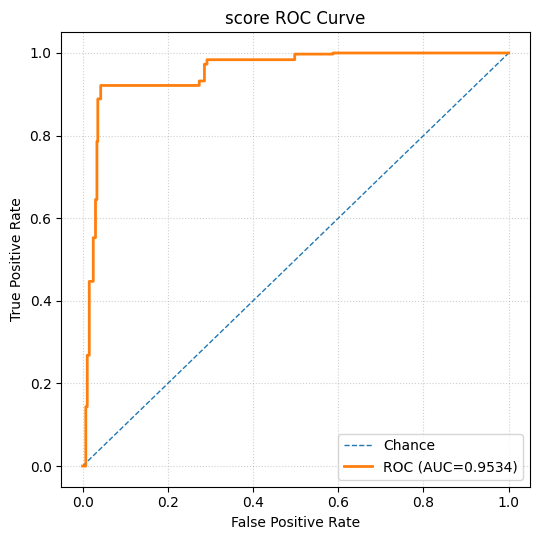

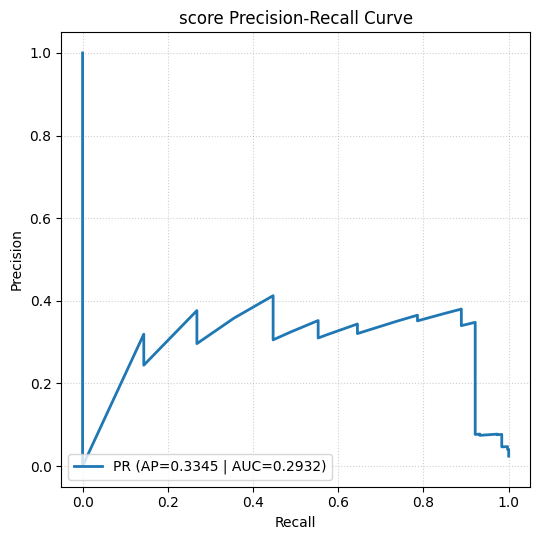

score ROC-AUC: 0.953404
score Average Precision (AP): 0.334513
score PR-AUC (trapz): 0.293171
Positives: 369 / 15346 (prevalence=0.0240)


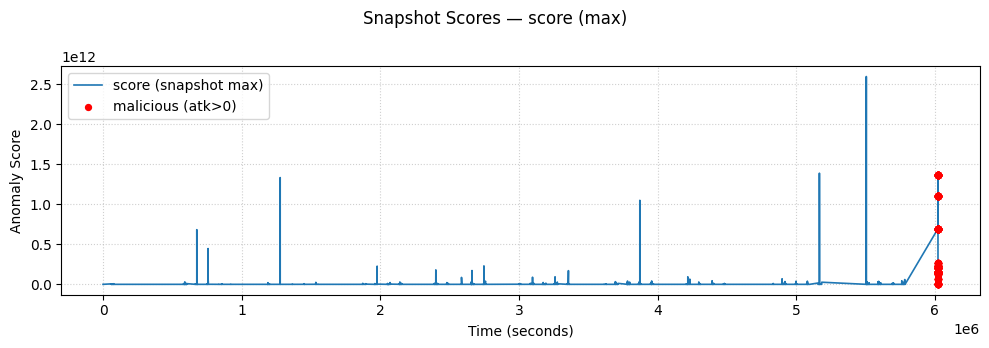

In [18]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "anomrank_user12_combined_or_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


Darpa Dataset, Darpa Dataset is large..Therefore when loaded onto excel, some data might get lost

In [54]:

df = pd.read_csv("darpa_edge_anomaly.csv")
print("score stats:", df["score"].min(), df["score"].max())

score stats: 0.0 207027406.797019


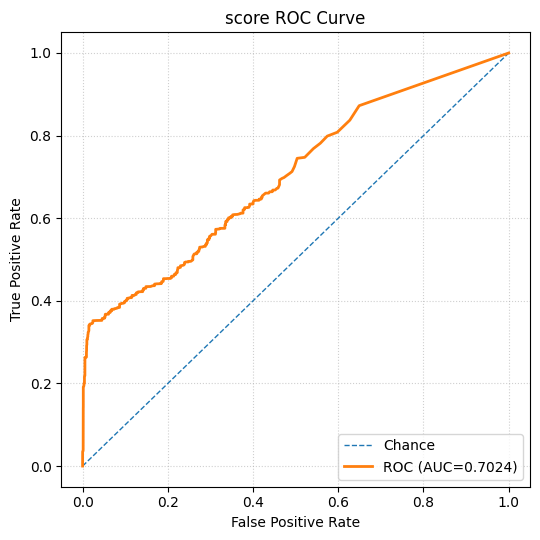

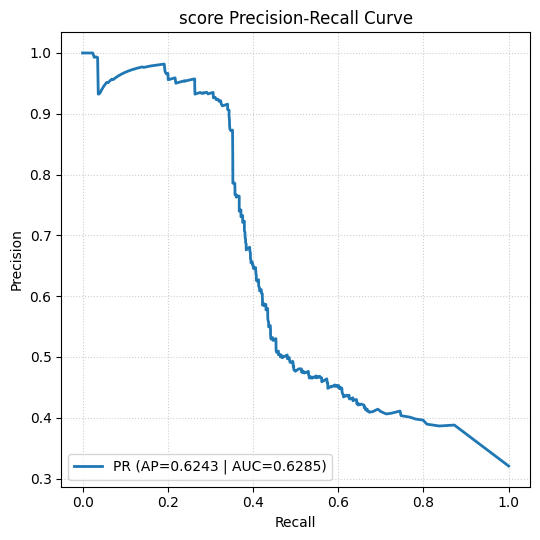

score ROC-AUC: 0.702414
score Average Precision (AP): 0.624327
score PR-AUC (trapz): 0.628528
Positives: 14926 / 46567 (prevalence=0.3205)


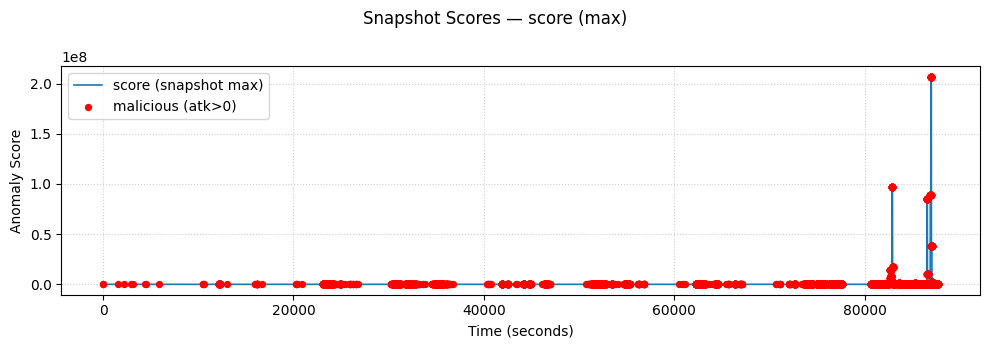

In [19]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "darpa_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")
